## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    x = input_layer
    for i, n_units in enumerate(num_neurons):
        x = keras.layers.Dense(units=n_units, 
                               activation="relu", 
                               name="hidden_layer"+str(i+1))(x)
        x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
import tensorflow as tf
import keras.backend as K

def focal_loss(gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        print(f"X={tf.reduce_mean(reduced_fl)}")
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

def combined_loss(ce_weight=0.7, fl_weight=0.3, gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)

    ce_weight = float(ce_weight)
    fl_weight = float(fl_weight)
    
    """
    Define the customized loss.
    loss function = 0.3 * focal_loss + 0.7 * cross-entropy
    """
    def combined_loss_fixed(y_true, y_pred):
        ce_loss = keras.losses.categorical_crossentropy(y_true, y_pred)

        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        focus_loss = tf.reduce_mean(reduced_fl)
        
        return (ce_weight * ce_loss) + (fl_weight * focus_loss)
    return combined_loss_fixed

In [8]:
ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [9]:
results = {}

for i, ce_w in enumerate(ce_weights_list):
    keras.backend.clear_session() # 把舊的 Graph 清掉

    model = build_mlp(input_shape=x_train.shape[1:])
    print(model.summary())

    print()
    print('-'*60)
    print(f"Experiment with crossentropy_weight={ce_w}")
    print()
    
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss=combined_loss(ce_weight=ce_w, fl_weight=1.0-ce_w), metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )

    # Collect results
    exp_name_tag = f"ce_weight:{ce_w}"
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}    

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batc

50000/50000 [==============================] - 9s 180us/step - loss: 2.7527 - acc: 0.5421 - val_loss: 3.3190 - val_acc: 0.4724
Epoch 7/25
50000/50000 [==============================] - 9s 178us/step - loss: 2.6242 - acc: 0.5608 - val_loss: 3.3368 - val_acc: 0.4648
Epoch 8/25
50000/50000 [==============================] - 9s 177us/step - loss: 2.5128 - acc: 0.5739 - val_loss: 3.3002 - val_acc: 0.4675
Epoch 9/25
50000/50000 [==============================] - 9s 178us/step - loss: 2.4026 - acc: 0.5933 - val_loss: 3.2817 - val_acc: 0.4661
Epoch 10/25
50000/50000 [==============================] - 9s 177us/step - loss: 2.3059 - acc: 0.6031 - val_loss: 3.2360 - val_acc: 0.4829
Epoch 11/25
50000/50000 [==============================] - 9s 178us/step - loss: 2.2010 - acc: 0.6189 - val_loss: 3.2017 - val_acc: 0.4878
Epoch 12/25
50000/50000 [==============================] - 9s 178us/step - loss: 2.0914 - acc: 0.6343 - val_loss: 3.2876 - val_acc: 0.4732
Epoch 13/25
50000/50000 [=================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 11s 223us/step - loss: 3.4186 - acc: 0.3038 - val_loss: 3.3755 - val_acc: 0.3250
Epoch 2/25
50000/50000 [==============================] - 9s 179us/step - loss: 2.5562 - acc: 0.4249 - val_loss: 2.7358 - val_acc: 0.4036
Epoch 3/25
50000/50000 [==============================] - 9s 180us/step - loss: 2.3382 - acc: 0.4645 - val_loss: 2.5066 - val_acc: 0.4330
Epoch 4/25
50000/50000 [==============================] - 9s 177us/step - loss: 2.2069 - acc: 0.4894 - val_loss: 2.4053 - val_acc: 0.4465
Epoch 5/25
50000/50000 [==============================] - 9s 179us/step - loss: 2.1098 - acc: 0.5083 - val_loss: 2.3625 - val_acc: 0.4533
Epoch 6/25
50000/50000 [==============================] - 9s 178us/step - loss: 2.0255 - acc: 0.5257 - val_loss: 2.3643 - val_acc: 0.4583
Epoch 7/25
50000/50000 [==============================] - 9s 181us/step - loss: 1.9542 - acc: 0.5428 - val_loss: 2.2791 -

50000/50000 [==============================] - 9s 181us/step - loss: 0.9849 - acc: 0.6666 - val_loss: 1.4494 - val_acc: 0.4969
Epoch 24/25
50000/50000 [==============================] - 9s 181us/step - loss: 0.9638 - acc: 0.6770 - val_loss: 1.4808 - val_acc: 0.4936
Epoch 25/25
50000/50000 [==============================] - 9s 185us/step - loss: 0.9434 - acc: 0.6822 - val_loss: 1.4649 - val_acc: 0.4985


In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline

def plot_data(results):
    NUM_COLORS = len(results.keys())

    cm = plt.get_cmap('gist_rainbow')
    cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
    color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.title("Loss")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.title("Accuracy")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

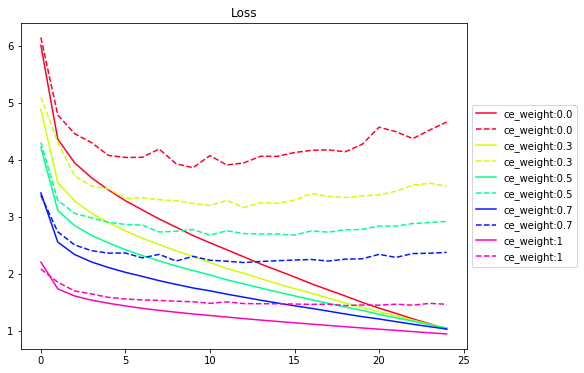

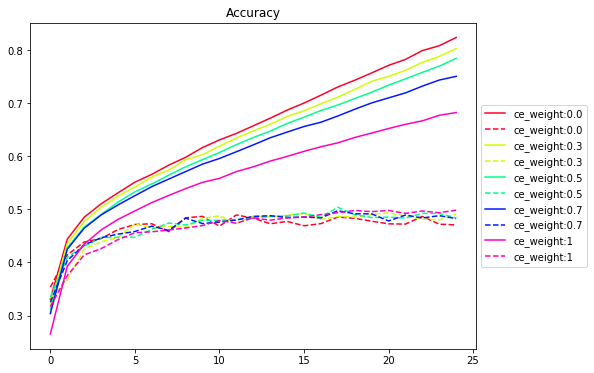

In [11]:
plot_data(results)

預期: loss=combined_loss(ce_weight = 0)  應等同於  loss=focal_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

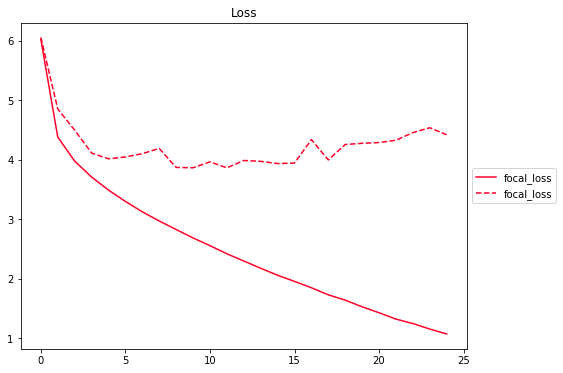

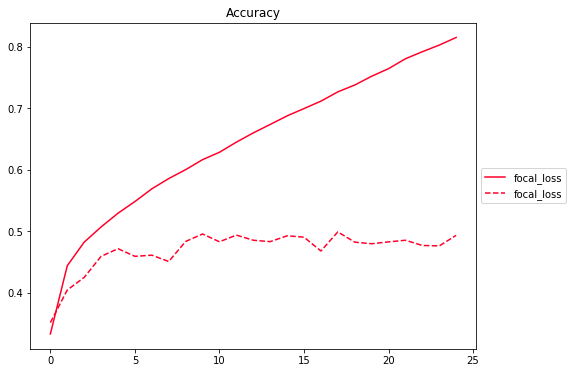

In [12]:
keras.backend.clear_session() # 把舊的 Graph 清掉
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss=focal_loss(), metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True
         )

results = {}
# Collect results
exp_name_tag = f"focal_loss"
results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                         'valid-loss': model.history.history["val_loss"],
                         'train-acc': model.history.history["acc"],
                         'valid-acc': model.history.history["val_acc"]}    

plot_data(results)

預期: loss=combined_loss(ce_weight = 1)  應等同於  loss=crossentropy

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

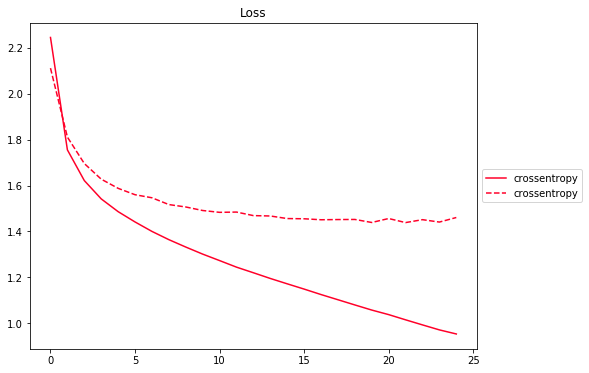

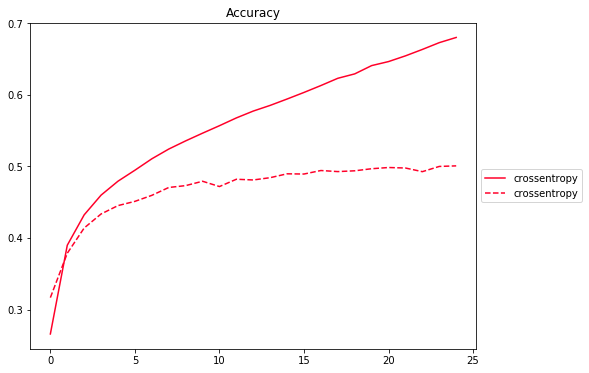

In [13]:
keras.backend.clear_session() # 把舊的 Graph 清掉
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True
         )

results = {}
# Collect results
exp_name_tag = f"crossentropy"
results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                         'valid-loss': model.history.history["val_loss"],
                         'train-acc': model.history.history["acc"],
                         'valid-acc': model.history.history["val_acc"]}    

plot_data(results)